In [76]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import os
import shutil
from torchvision import datasets
from torchvision.io import read_image
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
#copy non-plural material into a new folder
target_folder = "material_im_non_plu/"
source_folder = "material_images/"
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
    list = os.listdir(source_folder)
    for file_header in list:
        count = 0
        for char in file_header:
            if char == '1':
                count += 1
        if count == 1:
            shutil.copytree(source_folder + file_header, target_folder + file_header)


In [3]:
material_encoding = ['cloth',
 'metal',
 'fruit',
 'candle',
 'wood',
 'pottery',
 'shell',
 'plastic',
 'stone',
 'glass',
 'paper',
 'vegetable',
 'iron',
 'cane',
 'sponge',
 'rope',
 'foam',
 'rubber',
 'cotton',
 'velvet',
 'flower',
 'copper',
 'food',
 '',
 'wool',
 'wire',
 'elastic',
 'herbs',
 'plant',
 'feathers']
print(len(material_encoding))

30


In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(192*144*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 30),
        )
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        logits = self.softmax(logits)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=82944, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=30, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)


In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [63]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [64]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [65]:
#train model

#load data
dataset = datasets.ImageFolder(root = 'material_im_non_plu/', transform = ToTensor())

In [66]:
#split data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [67]:
#load data
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [68]:
epochs = 150
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.399990  [    0/ 7296]
loss: 2.973619  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.7%, Avg loss: 2.844885 

Epoch 2
-------------------------------
loss: 2.931786  [    0/ 7296]
loss: 2.732097  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.7%, Avg loss: 2.564131 

Epoch 3
-------------------------------
loss: 2.669318  [    0/ 7296]
loss: 2.601863  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.7%, Avg loss: 2.434856 

Epoch 4
-------------------------------
loss: 2.533262  [    0/ 7296]
loss: 2.527641  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.7%, Avg loss: 2.366992 

Epoch 5
-------------------------------
loss: 2.464825  [    0/ 7296]
loss: 2.481571  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.4%, Avg loss: 2.324164 

Epoch 6
-------------------------------
loss: 2.421995  [    0/ 7296]
loss: 2.443971  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.3%, Avg loss: 2.291670 

Epoch 7
-------------------------------
loss: 2.387847  [    0/ 7296]
loss: 2.410007  [ 

In [69]:
#predict 
def predict_image(img, model):
    # Convert to a batch of 1
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(img)
        return pred


In [70]:
def material_encoding_to_string(binary_str):
    for index, char in enumerate(str(binary_str)):
        if char == '1':
            return material_encoding[index]
    return "no encoding found"
        

In [71]:
train_dataset.dataset.class_to_idx

{'000000000000000000000000000001': 0,
 '000000000000000000000000010000': 1,
 '000000000000000000000001000000': 2,
 '000000000000000000000010000000': 3,
 '000000000000000000000100000000': 4,
 '000000000000000000001000000000': 5,
 '000000000000000000100000000000': 6,
 '000000000000000001000000000000': 7,
 '000000000000000010000000000000': 8,
 '000000000000000100000000000000': 9,
 '000000000000001000000000000000': 10,
 '000000000000010000000000000000': 11,
 '000000000001000000000000000000': 12,
 '000000000010000000000000000000': 13,
 '000000000100000000000000000000': 14,
 '000000001000000000000000000000': 15,
 '000000010000000000000000000000': 16,
 '000000100000000000000000000000': 17,
 '000001000000000000000000000000': 18,
 '000010000000000000000000000000': 19,
 '000100000000000000000000000000': 20,
 '001000000000000000000000000000': 21,
 '010000000000000000000000000000': 22,
 '100000000000000000000000000000': 23}

In [72]:
def index_to_class(index):
    classes = train_dataset.dataset.class_to_idx
    for key, value in classes.items():
        if value == index:
            return key

In [82]:
result = predict_image(test_dataset[50][0], model)
actual = test_dataset[50][1]
print(f"Predicted class: {index_to_class(result.argmax(1).item())}, Actual class: {index_to_class(actual)}")
print(f"Predicted material: {material_encoding_to_string(index_to_class(result.argmax(1).item()))}, Actual material: {material_encoding_to_string(index_to_class(actual))}")

Predicted class: 000000010000000000000000000000, Actual class: 000000010000000000000000000000
Predicted material: plastic, Actual material: plastic


In [83]:
#probability of each material
result = predict_image(test_dataset[1][0], model)
sum = 0
for index, probability in enumerate(result[0]):
    #mark the highest probability
    if index == result.argmax(1).item():
        print(f"{material_encoding_to_string(index_to_class(index))}: {math.exp(probability.item()) * 100}%, <---")
    else:
        print("index:" + str(index))
        print(f"{material_encoding_to_string(index_to_class(index))}: {math.exp(probability.item()) * 100}%")
    sum += math.exp(probability.item())

index:0
feathers: 0.0719102002382465%
index:1
wire: 0.2768298098473211%
index:2
: 1.1327804774783812%
index:3
food: 0.7489489176985731%
index:4
copper: 0.34330984493866235%
index:5
flower: 0.11154592295671871%
index:6
cotton: 0.12529006550238447%
index:7
rubber: 0.325789317867564%
index:8
foam: 0.052973143229067016%
index:9
rope: 0.06067070491511847%
index:10
sponge: 0.0986145472232454%
index:11
cane: 0.12930252331118972%
index:12
vegetable: 1.9038218686459318%
index:13
paper: 0.03170307204114061%
index:14
glass: 0.6995726967637127%
index:15
stone: 0.8296839601415926%
plastic: 87.67596074723066%, <---
index:17
shell: 0.05893805071991934%
index:18
pottery: 0.46518110726217465%
index:19
wood: 1.9956296768795094%
index:20
candle: 0.31923306038121013%
index:21
fruit: 1.0333449733840556%
index:22
metal: 0.6553133124468715%
index:23
cloth: 0.7311444220579252%
index:24
no encoding found: 0.017140863879967532%
index:25
no encoding found: 0.0220179333470725%
index:26
no encoding found: 0.019177

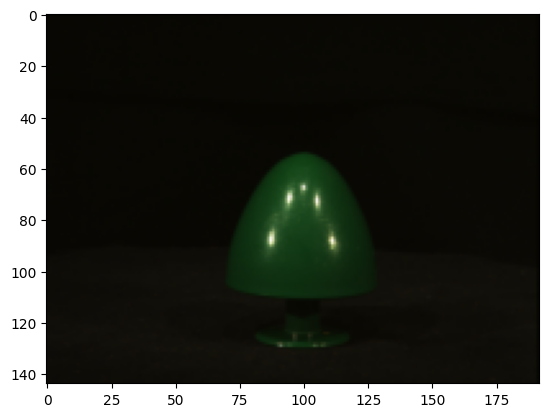

In [86]:
#print image
plt.imshow(test_dataset[1][0].permute(1, 2, 0))
plt.show()

In [87]:
#save model
torch.save(model.state_dict(), "model_noplural_log_softmax.pth")